# M5 Forecast: Poisson loss (top 10%)

This very simple script was lucky enough to get top 10% in private lb. 

I moved the time horizon of the previous version of this notebook by 28 days and removed all "magic" stuff. The winning solutions did clearly better in terms of performance, but simplicity is worth a lot when it comes to maintainance etc.

In [1]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb

## Load data

In [2]:
path = "../input/m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_evaluation.csv"))

## Prepare calendar data

In [3]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_type_1", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_name_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


## Helper functions

We need the following functions.

In [4]:
from sklearn.model_selection import train_test_split

LAGS = [7, 28]
WINDOWS = [7, 28]
FIRST = 1942 # first to predict
LENGTH = 28

def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

def prep_data(df, drop_d=1000):
    """ Prepare model data sets """
    
    # Kick out old dates
    df = df.drop(["d_" + str(i+1) for i in range(drop_d)], axis=1)

    # Reshape to long
    df = df.assign(id=df.id.str.replace("_evaluation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(FIRST + i) for i in range(LENGTH)])
    df = df.melt(id_vars=["id", "item_id", "store_id", "state_id", "dept_id", "cat_id"], var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"),
                   demand=df.demand.astype("float32"))
    
    # Add demand features
    df = demand_features(df)
    
    # Remove rows with NAs
    df = df[df.d > (drop_d + max(LAGS) + max(WINDOWS))]
 
    # Join calendar & prices
    df = df.merge(calendar, how="left", on="d")
    df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
    df = df.drop(["wm_yr_wk"], axis=1)
    
    # Ordinal encoding of remaining categorical fields
    for v in ["item_id", "store_id", "state_id", "dept_id", "cat_id"]:
        df[v] = OrdinalEncoder(dtype="int").fit_transform(df[[v]]).astype("int16") + 1
    
    # Determine list of covariables
    x = list(set(df.columns) - {'id', 'd', 'demand'})
            
    # Split into test, valid, train
    test = df[df.d >= FIRST - max(LAGS) - max(WINDOWS) - 28]
    df = df[df.d < FIRST]

    xtrain, xvalid, ytrain, yvalid = train_test_split(df[x], df["demand"], test_size=0.1, shuffle=True, random_state=54)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xvalid, label = yvalid)

    return train, valid, test, x

def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.08,
        'lambda': 0.1,
        'num_leaves': 63,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.7
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 2000, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

def pred_all(fit, test, x):
    """ Calculate predictions """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x])
    
    return test

def pred_to_csv(test, cols=sample_submission.columns, file="submission.csv"):
    """ Reshape predictions and save submission csv """
     
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + LENGTH + 1 - LENGTH * (test.d >= FIRST)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

## Run the code

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.26326
[200]	valid_0's rmse: 2.23133
[300]	valid_0's rmse: 2.20281
[400]	valid_0's rmse: 2.18845
[500]	valid_0's rmse: 2.1778
[600]	valid_0's rmse: 2.16958
[700]	valid_0's rmse: 2.16296
[800]	valid_0's rmse: 2.15784
[900]	valid_0's rmse: 2.15305
[1000]	valid_0's rmse: 2.14934
[1100]	valid_0's rmse: 2.14473
[1200]	valid_0's rmse: 2.14086
[1300]	valid_0's rmse: 2.13785
[1400]	valid_0's rmse: 2.13501
[1500]	valid_0's rmse: 2.13275
[1600]	valid_0's rmse: 2.1302
[1700]	valid_0's rmse: 2.1278
[1800]	valid_0's rmse: 2.12625
[1900]	valid_0's rmse: 2.12409
[2000]	valid_0's rmse: 2.1224
Did not meet early stopping. Best iteration is:
[1997]	valid_0's rmse: 2.12234


True

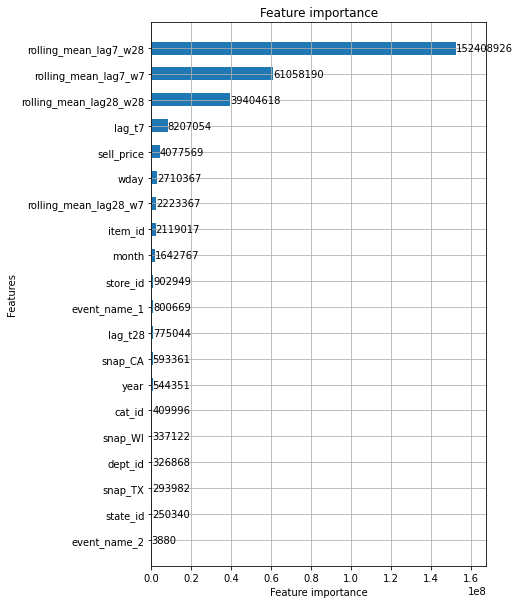

In [5]:
train, valid, test, x = prep_data(sales, 1000 - 28)
fit = fit_model(train, valid)
pred = pred_all(fit, test, x)
pred_to_csv(pred, cols=sample_submission.columns, file="submission.csv")